In [1]:
#!pip install pyspark

# Imports

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import sys
import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

import numpy as np

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Imputer
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel
from pyspark.ml.feature import VectorAssembler


from dtreeviz.models.spark_decision_tree import ShadowSparkTree
from dtreeviz import trees

# spark/data setup

In [4]:
spark = SparkSession.builder \
            .master("local[2]") \
            .appName("dtreeviz_sparkml") \
            .getOrCreate()

In [5]:
data = spark.read.csv("../data/titanic/titanic.csv", header=True, inferSchema=True)

In [6]:
data.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [7]:
data.describe().toPandas()

,summary,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,count,891,891,891,891,891,714,891,891,891,891,204,889
1,mean,446.0,0.3838383838383838,2.308641975308642,None,None,29.69911764705882,0.5230078563411896,0.38159371492704824,260318.54916792738,32.2042079685746,None,None
2,stddev,257.3538420152301,0.48659245426485753,0.8360712409770491,None,None,14.526497332334035,1.1027434322934315,0.8060572211299488,471609.26868834975,49.69342859718089,None,None
3,min,1,0,1,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""",female,0.42,0,0,110152,0.0,A10,C
4,max,891,1,3,"van Melkebeke, Mr. Philemon",male,80.0,8,6,WE/P 5735,512.3292,T,S


# Feature transformation

## Sex, embarked indexer

In [8]:
label_indexer = StringIndexer(inputCols=["Sex", "Embarked"], outputCols=["Sex_label", "Embarked_label"], handleInvalid="keep")
label_indexer.fit(data).transform(data)


DataFrame[PassengerId: int, Survived: int, Pclass: int, Name: string, Sex: string, Age: double, SibSp: int, Parch: int, Ticket: string, Fare: double, Cabin: string, Embarked: string, Sex_label: double, Embarked_label: double]

In [9]:
label_indexer.fit(data).transform(data).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_label,Embarked_label
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S,1.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,None,S,0.0,0.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1.0,0.0
888,889,0,3,"""Johnston, Miss. Catherine Helen """"Carrie""""""",female,NaN,1,2,W./C. 6607,23.4500,None,S,1.0,0.0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0.0,1.0


## age

In [10]:
age_imputer = Imputer(inputCol="Age", outputCol="Age_mean")
# age_imputer.fit(data).transform(data).toPandas()

# vector assembler

In [11]:
features = ["Pclass", "Sex_label", "Embarked_label", "Age_mean", "SibSp", "Parch", "Fare"]
target = "Survived"

In [12]:
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")

# Define decision tree 

In [13]:
decision_tree = DecisionTreeClassifier(featuresCol="features", labelCol="Survived", maxDepth=4, seed=1234)

# Define the pipeline

In [14]:
pipeline = Pipeline(stages=[label_indexer, age_imputer, vector_assembler, decision_tree])
model = pipeline.fit(data)

In [15]:
model.transform(data).printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Sex_label: double (nullable = false)
 |-- Embarked_label: double (nullable = false)
 |-- Age_mean: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [16]:
model.transform(data).select(["features", "Survived", "rawPrediction", "prediction"]).toPandas()

,features,Survived,rawPrediction,prediction
0,"[3.0, 0.0, 0.0, 22.0, 1.0, 0.0, 7.25]",0,"[463.0, 96.0]",0.0
1,"[1.0, 1.0, 1.0, 38.0, 1.0, 0.0, 71.2833]",1,"[8.0, 159.0]",1.0
2,"[3.0, 1.0, 0.0, 26.0, 0.0, 0.0, 7.925]",1,"[35.0, 31.0]",0.0
3,"[1.0, 1.0, 0.0, 35.0, 1.0, 0.0, 53.1]",1,"[8.0, 159.0]",1.0
4,"(3.0, 0.0, 0.0, 35.0, 0.0, 0.0, 8.05)",0,"[463.0, 96.0]",0.0
...,...,...,...,...
886,"(2.0, 0.0, 0.0, 27.0, 0.0, 0.0, 13.0)",0,"[463.0, 96.0]",0.0
887,"[1.0, 1.0, 0.0, 19.0, 0.0, 0.0, 30.0]",1,"[8.0, 159.0]",1.0
888,"[3.0, 1.0, 0.0, 29.69911764705882, 1.0, 2.0, 2...",0,"[35.0, 31.0]",0.0
889,"[1.0, 0.0, 1.0, 26.0, 0.0, 0.0, 30.0]",1,"[463.0, 96.0]",0.0


In [17]:
features

['Pclass', 'Sex_label', 'Embarked_label', 'Age_mean', 'SibSp', 'Parch', 'Fare']

In [18]:
print(model.stages[3].toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_0b3be2f52cad, depth=4, numNodes=17, numClasses=2, numFeatures=7
  If (feature 1 in {0.0})
   If (feature 3 <= 3.5)
    If (feature 4 <= 2.5)
     Predict: 1.0
    Else (feature 4 > 2.5)
     Predict: 0.0
   Else (feature 3 > 3.5)
    Predict: 0.0
  Else (feature 1 not in {0.0})
   If (feature 0 <= 2.5)
    If (feature 3 <= 3.5)
     If (feature 0 <= 1.5)
      Predict: 0.0
     Else (feature 0 > 1.5)
      Predict: 1.0
    Else (feature 3 > 3.5)
     Predict: 1.0
   Else (feature 0 > 2.5)
    If (feature 6 <= 24.808349999999997)
     If (feature 2 in {1.0,2.0})
      Predict: 1.0
     Else (feature 2 not in {1.0,2.0})
      Predict: 0.0
    Else (feature 6 > 24.808349999999997)
     Predict: 0.0



In [ ]:
def _get_root_node(tree: DecisionTreeClassificationModel):
    return tree._call_java('rootNode')

def get_impurities(tree: DecisionTreeClassificationModel):
    def recur(node):
        if node.numDescendants() == 0:
            return []
        ni = node.impurity()
        return (
            recur(node.leftChild()) + [ni] + recur(node.rightChild())
        )
    return recur(_get_root_node(tree))

def get_feature_index(tree: DecisionTreeClassificationModel):
    def recur(node):
        if node.numDescendants() == 0:
            return []
        ni = node.split().featureIndex()
        return (
            [ni] + recur(node.leftChild()) + recur(node.rightChild())
        )
    return recur(_get_root_node(tree))

def get_node_children_id(tree: DecisionTreeClassificationModel):
    nodes = [None] * tree.numNodes
    children_left = [-1] * tree.numNodes
    children_right = [-1] * tree.numNodes
    node_index = 0    
        
        
    def recur(node, node_id):
        nonlocal node_index
        nodes[node_id] = node
        if node.numDescendants() == 0:
            return
        else:
            node_index += 1
            children_left[node_id] = node_index
            print(f"node, node_left {node_id, node_index}")
            recur(node.leftChild(), node_index)
            
            node_index += 1
            children_right[node_id] = node_index
            print(f"node, node_right {node_id, node_index}")
            recur(node.rightChild(), node_index)
    recur(_get_root_node(tree), 0)
    return nodes, children_left, children_right
                  
                     

In [29]:
#model.stages[3]._call_java('rootNode').toString()

In [27]:
dir(model.stages[3]._call_java('rootNode'))

['$anonfun$toOld$1',
 'deepCopy',
 'equals',
 'fromOld',
 'gain',
 'getClass',
 'hashCode',
 'impurity',
 'impurityStats',
 'leftChild',
 'maxSplitFeatureIndex',
 'notify',
 'notifyAll',
 'numDescendants',
 'predictBinned',
 'predictImpl',
 'prediction',
 'rightChild',
 'split',
 'subtreeDepth',
 'subtreeToString',
 'subtreeToString$default$1',
 'toOld',
 'toString',
 'wait']

In [33]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.tree import

In [39]:
Vectors.dense([3.0, 0.0, 0.0, 22.0, 1.0, 0.0, 7.25])

DenseVector([3.0, 0.0, 0.0, 22.0, 1.0, 0.0, 7.25])

In [32]:
model.stages[3]._call_java('rootNode').split().featureIndex()

1

In [84]:
list(model.stages[3]._call_java('rootNode').split().rightCategories())

[1.0, 2.0]

In [85]:
isinstance(model.stages[3]._call_java('rootNode').split(), 

JavaObject id=o730

In [66]:
dir(model.stages[3]._call_java('rootNode').split())

['$anonfun$hashCode$1',
 '$anonfun$hashCode$1$adapted',
 '$anonfun$hashCode$2',
 '$anonfun$new$1',
 '$anonfun$new$2',
 '$anonfun$setComplement$1',
 '$anonfun$setComplement$2',
 'equals',
 'featureIndex',
 'getClass',
 'hashCode',
 'leftCategories',
 'notify',
 'notifyAll',
 'numCategories',
 'rightCategories',
 'shouldGoLeft',
 'toOld',
 'toString',
 'wait']

In [ ]:
nodes, children_left, children_right = get_node_children_id(model.stages[3])

In [ ]:
_get_root_node(model.stages[3]).split().leftCategories()

In [ ]:
dir(_get_root_node(model.stages[3]).split())

In [ ]:
dir(_get_root_node(model.stages[3]).impurityStats())

In [ ]:
_get_root_node(model.stages[3]).impurityStats().rawCount()

# dtreeviz

In [29]:
tree_model_classifier = model.stages[3]
print(tree_model_classifier)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_f341a7a00c21, depth=4, numNodes=17, numClasses=2, numFeatures=7


In [30]:
#tree_model_classifier.save("/Users/tudorl/Documents/workspace/personal/dtreeviz/testing/dtreeviz/models/fixtures/spark_decision_tree_classifier.model")
#DecisionTreeClassificationModel.load("/Users/tudorl/Documents/workspace/personal/dtreeviz/testing/dtreeviz/models/fixtures/spark_decision_tree_classifier.model")

In [61]:
df = spark.read.parquet("/Users/tudorl/Documents/workspace/personal/dtreeviz/testing/dtreeviz/models/fixtures/spark_decision_tree_classifier.model/data")

In [63]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- prediction: double (nullable = true)
 |-- impurity: double (nullable = true)
 |-- impurityStats: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- rawCount: long (nullable = true)
 |-- gain: double (nullable = true)
 |-- leftChild: integer (nullable = true)
 |-- rightChild: integer (nullable = true)
 |-- split: struct (nullable = true)
 |    |-- featureIndex: integer (nullable = true)
 |    |-- leftCategoriesOrThreshold: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- numCategories: integer (nullable = true)



In [74]:
features

['Pclass', 'Sex_label', 'Embarked_label', 'Age_mean', 'SibSp', 'Parch', 'Fare']

In [40]:
df

,id,prediction,impurity,impurityStats,rawCount,gain,leftChild,rightChild,split
0,0,0.0,0.473013,"[549.0, 342.0]",891,0.139648,1,6,"(1, [0.0], 3)"
1,1,0.0,0.306444,"[468.0, 109.0]",577,0.018317,2,5,"(3, [3.5], -1)"
2,2,1.0,0.401235,"[5.0, 13.0]",18,0.308642,3,4,"(4, [2.5], -1)"
3,3,1.0,0.000000,"[0.0, 12.0]",12,-1.000000,-1,-1,"(-1, [], -1)"
4,4,0.0,0.277778,"[5.0, 1.0]",6,-1.000000,-1,-1,"(-1, [], -1)"
5,5,0.0,0.284484,"[463.0, 96.0]",559,-1.000000,-1,-1,"(-1, [], -1)"
6,6,1.0,0.382835,"[81.0, 233.0]",314,0.099246,7,12,"(0, [2.5], -1)"
7,7,1.0,0.100277,"[9.0, 161.0]",170,0.002825,8,11,"(3, [3.5], -1)"
8,8,1.0,0.444444,"[1.0, 2.0]",3,0.444444,9,10,"(0, [1.5], -1)"
9,9,0.0,0.000000,"[1.0, 0.0]",1,-1.000000,-1,-1,"(-1, [], -1)"


In [24]:
features + [target]

['Pclass',
 'Sex_label',
 'Embarked_label',
 'Age_mean',
 'SibSp',
 'Parch',
 'Fare',
 'Survived']

In [32]:
dataset = Pipeline(stages=[label_indexer, age_imputer]) \
    .fit(data) \
    .transform(data) \
    .toPandas()[features + [target]]



In [ ]:
spark_dtree = ShadowSparkTree(tree_model_classifier, dataset[features], dataset[target], feature_names=features, target_name=target)

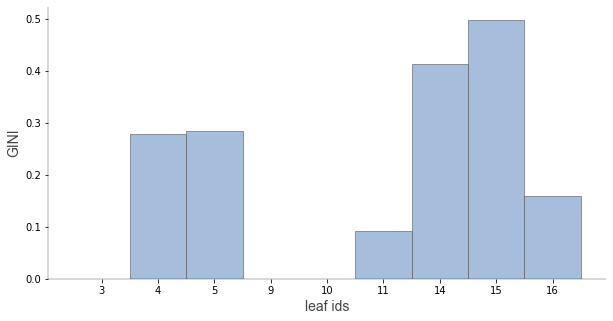

In [35]:
trees.viz_leaf_criterion(spark_dtree)

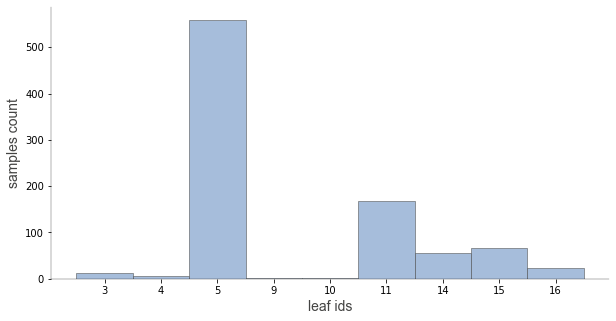

In [37]:
trees.viz_leaf_samples(spark_dtree)